## Import libraries

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy, pickle, os, time
import zipfile as zf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import seaborn as sns


## Load the dataset in the notebook

In [3]:
files = zf.ZipFile("data_upload_v3.zip", 'r')
files.extractall('directory to extract')
files.close()
dataset_path='./directory to extract/data'
data_dir = dataset_path

##  We have three objectives:

 1. Apply augumentation to create transformed version of COVID-19 images (such as flipping, small rotation, adding small amount of distortions), to increase the number of samples by a factor of 5.

 2. Fine-tune the last layer of the pre-trained version of these models on ImageNet. In this way, the model can be trained with less labeled samples from each class. Because it is relatively rare to have a dataset of sufficient size, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.
 3. Comparison of two resnet models of resnet 18 and resnet 50
 3. Create an application to ease the procedures for users

## Exploretory data analysis (EDA)

We have 3100 images in our test dataset in Covid-Chestxray-Dataset, 3000 cases are non-covid and 100 cases are images labled as covid cases. 

We also have 2084 images in our train dataset. Out of 2084 images, 2000 images are labeled as non-covid cases and the rest 84 cases are covid cases. After augmentation we have 420 cases of covid cases.

In our validation dataset, there are 100 cases of covid images and 


In [4]:
# Make a dictionary containing both train and validation data

start_time= time.time()
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomResizedCrop(224), # crop the image randomely
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224), # crop the (224*224) image from centre
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x))
                  for x in ['train', 'val']}



## Build the dataset and applying augumentation 

In [5]:
# A technique to increase the diversity of your training set by applying random transformations.

start_time= time.time()
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomResizedCrop(224), # crop the image randomely
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224), # crop the (224*224) image from centre
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= 20,
                                             shuffle=True, num_workers= 0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes  ## 0: child, and 1: nonchild


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [6]:
# Undrestanding the data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import data
metadata_dir = 'metadata.csv'
metadata = pd.read_csv(metadata_dir)
# what info do we have?
print(metadata.columns)

Index(['patientid', 'offset', 'sex', 'age', 'finding', 'RT_PCR_positive',
       'survival', 'intubated', 'intubation_present', 'went_icu', 'in_icu',
       'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation',
       'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view',
       'modality', 'date', 'location', 'folder', 'filename', 'doi', 'url',
       'license', 'clinical_notes', 'other_notes', 'Unnamed: 29'],
      dtype='object')


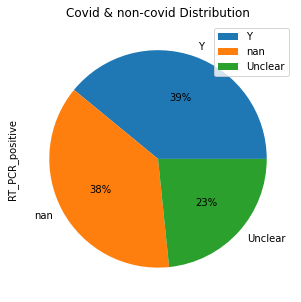

In [7]:
# Let's analyze the distribution of the target values
#(nan if unknown)

ax = metadata['RT_PCR_positive'].value_counts(dropna=False).plot.pie(y='Y', legend = True, autopct='%2.0f%%', figsize = (5,5), title = 'Covid & non-covid Distribution')

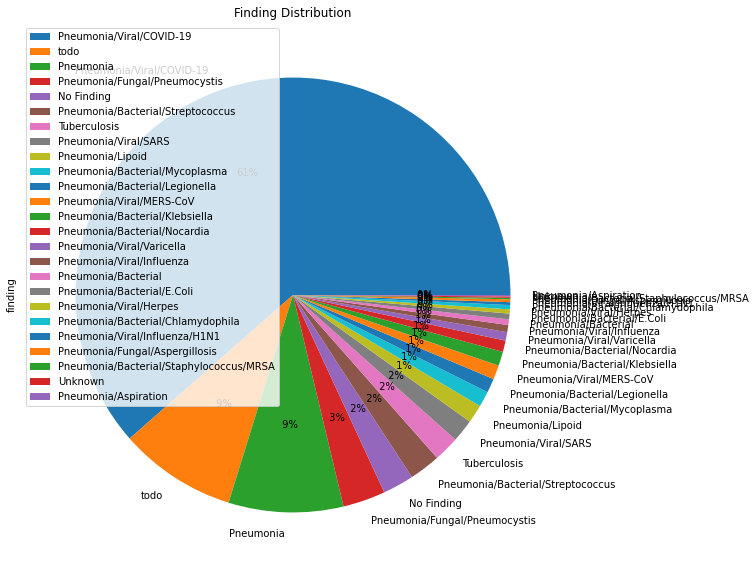

In [8]:
# Finding distribution (nan if unknown)

metadata_dir = 'metadata.csv'
metadata = pd.read_csv(metadata_dir)
ax = metadata['finding'].value_counts(dropna=False).plot.pie(y='Finding', legend = True, autopct='%2.0f%%', figsize = (10,10), title = 'Finding Distribution')

In [9]:
# Load features of dataset and check columns and values
file_df = pd.read_csv('metadata.csv', header=0)
file_df.head()

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


## Split the values 

In [10]:
# To get each category for each sample in our dataset, we need to split the values in the finding column by space character:
all_cats_df = pd.DataFrame(file_df)

all_cats_df['cats_split'] = all_cats_df['finding'].str.split()


In [11]:
# How many diffrent illness category exist in the finding column?

In [12]:
cats = all_cats_df['cats_split'].sum()
unique_cats = set(cats)
len(unique_cats)

26

In [13]:
# Now, we look at the distribution of the diffent categories caused desease 

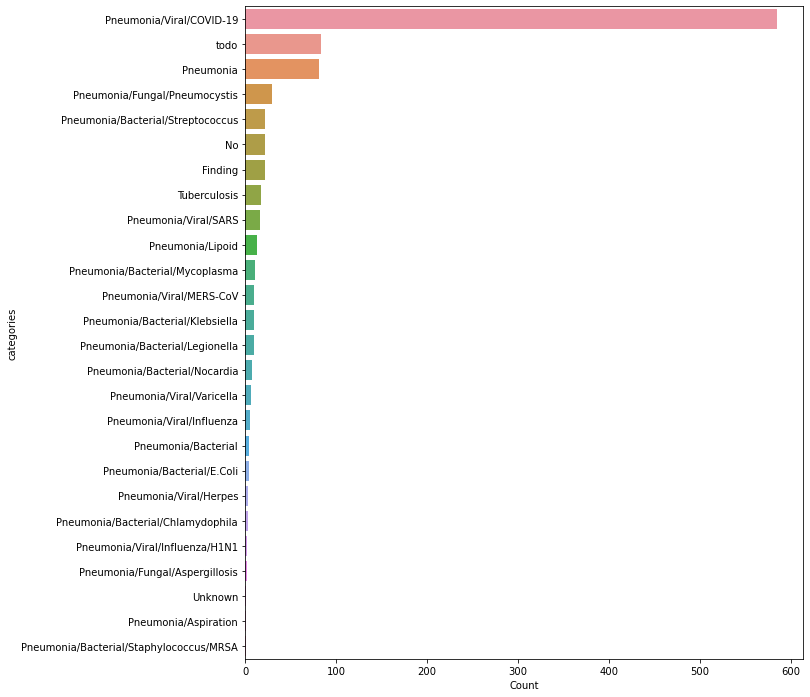

In [14]:
all_cats = nltk.FreqDist(cats) 
all_cats_df = pd.DataFrame({'categories': list(all_cats.keys()), 
                              'Count': list(all_cats.values())})
most_freq_cats = all_cats_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(10,12)) 
ax = sns.barplot(data=most_freq_cats, x= "Count", y = "categories")
plt.show()

## Show some of images 

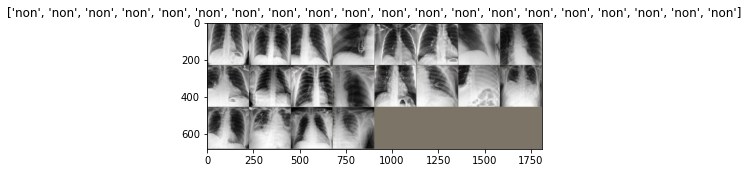

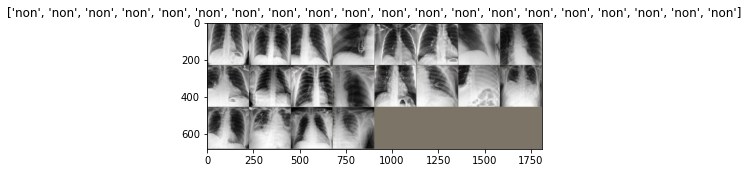

In [15]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def imshow(inp, title= None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# call the imshow function defined in above section
imshow(out, title=[class_names[x] for x in classes])
inputs, classes = next(iter(dataloaders['train']))

imshow(out, title=[class_names[x] for x in classes])
inputs, classes = next(iter(dataloaders['val']))

## Training model

In [ ]:
# Before defining a function to train our model, I will clarify each line of code separately

In [ ]:
# Copy weights and biases of the pre-trained model into our model. By using transfer learning, the model parameters start with already-good initial values that only need some small 
# modifications to be better curated toward the new task

# We used the pre-trained model to re-purposed to our related task. 

best_model_wts = copy.deepcopy(model.state_dict())    

In [30]:
# print the epoch number to know which iteration number we are in
num_epochs= 3
for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

Epoch 1/3
----------
Epoch 2/3
----------
Epoch 3/3
----------


In [16]:
# Define a function to train our model
def train_model(model, criterion, optimizer, scheduler, batch_szie, num_epochs):
    # The number of epochs is a hyperparameter that defines 
    # the number times that the learning algorithm will work through the entire training dataset
    since = time.time() 
    
    best_model_wts = copy.deepcopy(model.state_dict()) # Copy weights and biases of the pre-trained model into our model
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step() ## Adjust the learning rate based on the number of epochs
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
# Set the initial value of variables 
            best_acc = 0.0
            train_acc= list()
            valid_acc= list()
            running_loss = 0.0
            running_corrects = 0
            running_prec= 0.0
            running_rec = 0.0
            running_f1  = 0.0

            # Iterate over data.
            cur_batch_ind= 0
            for inputs, labels in dataloaders[phase]:
                print(cur_batch_ind,"batch inputs shape:", inputs.shape)
                print(cur_batch_ind,"batch label shape:", labels.shape)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'): ## It makes sure to clear the intermediate values
                    ## for evaluation, which are needed to backpropagate during training, 
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # Returns the maximum value of all elements in the input tensor
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step() # hold the current state and will update the parameters based on the computed gradient

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                cur_acc= torch.sum(preds == labels.data).double()/batch_szie
                cur_batch_ind +=1
                print("\npreds:", preds)
                print("label:", labels.data)
                print("%d-th epoch, %d-th batch (size=%d), %s acc= %.3f \n" %(epoch+1, cur_batch_ind, len(labels), phase, cur_acc ))
                
                if phase=='train':
                    train_acc.append(cur_acc) ## append all the accuracy related to each epoch
                else:
                    valid_acc.append(cur_acc)
            
            ## calculation of accuracy for validation data   
            
            epoch_loss= running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f} \n\n'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch= epoch
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc= %.3f at Epoch: %d' %(best_acc,best_epoch) )

   # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, valid_acc


In [17]:

#### load the first model Reznet18

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False ## All new operations in the torch.set_grad_enabled(False) block won’t require gradients. 
    ## However, the model parameters will still require gradients.
    
    # Parameters of newly constructed modules have requires_grad=True by default   

num_ftrs = model_conv.fc.in_features        
model_conv.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr= 0.0001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)



C:\Users\Homa\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Homa\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Calling train_model function

In [18]:

if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, 10, 3)
    model_conv.eval()
    torch.save(model_conv, './covid_resnet18_epoch%d.pt' %100)
  

Epoch 1/2
----------


C:\Users\Homa\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


0 batch inputs shape: torch.Size([20, 3, 224, 224])
0 batch label shape: torch.Size([20])

preds: tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0])
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
1-th epoch, 1-th batch (size=20), train acc= 0.500 

1 batch inputs shape: torch.Size([20, 3, 224, 224])
1 batch label shape: torch.Size([20])

preds: tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0])
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])
1-th epoch, 2-th batch (size=20), train acc= 0.700 

2 batch inputs shape: torch.Size([20, 3, 224, 224])
2 batch label shape: torch.Size([20])

preds: tensor([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0])
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
1-th epoch, 3-th batch (size=20), train acc= 0.600 

3 batch inputs shape: torch.Size([20, 3, 224, 224])
3 batch label shape: torch.Size([20])

preds: tensor([1, 1, 

In [19]:
# Calculation of time spent on training
end_time= time.time()
print("total_time tranfer learning=", end_time - start_time) 

total_time tranfer learning= 2434.9453418254852


## Visualize the model

In [20]:
def visualize_model(model, num_images= 8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images/8, 8, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)




<ipython-input-20-e8db128c4244>:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(num_images/8, 8, images_so_far)


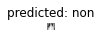

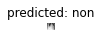

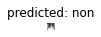

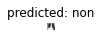

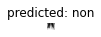

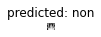

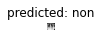

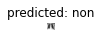

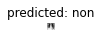

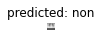

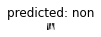

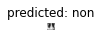

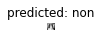

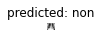

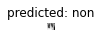

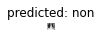

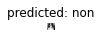

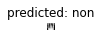

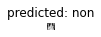

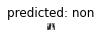

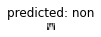

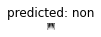

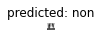

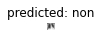

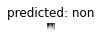

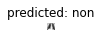

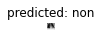

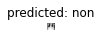

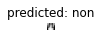

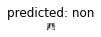

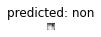

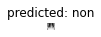

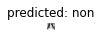

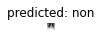

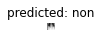

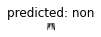

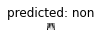

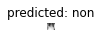

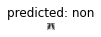

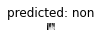

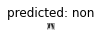

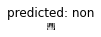

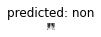

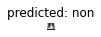

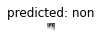

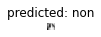

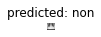

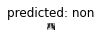

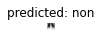

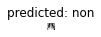

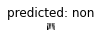

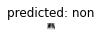

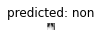

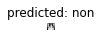

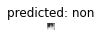

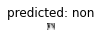

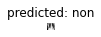

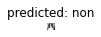

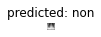

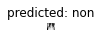

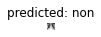

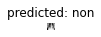

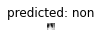

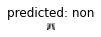

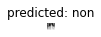

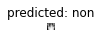

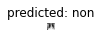

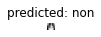

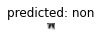

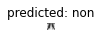

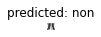

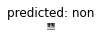

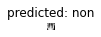

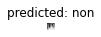

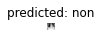

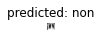

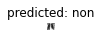

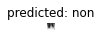

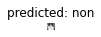

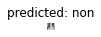

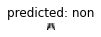

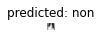

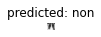

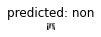

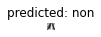

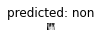

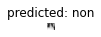

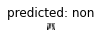

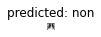

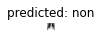

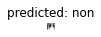

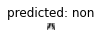

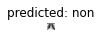

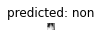

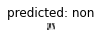

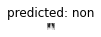

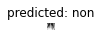

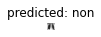

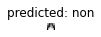

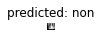

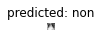

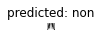

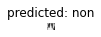

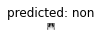

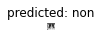

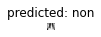

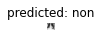

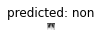

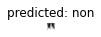

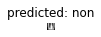

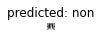

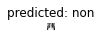

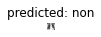

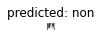

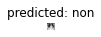

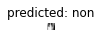

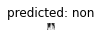

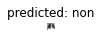

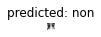

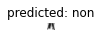

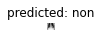

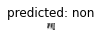

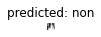

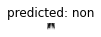

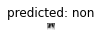

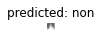

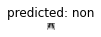

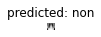

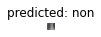

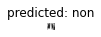

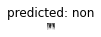

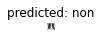

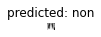

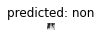

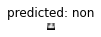

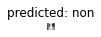

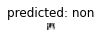

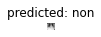

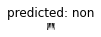

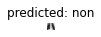

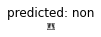

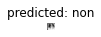

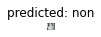

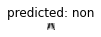

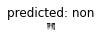

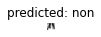

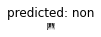

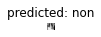

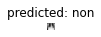

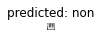

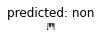

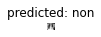

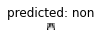

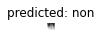

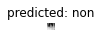

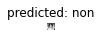

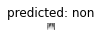

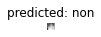

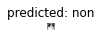

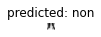

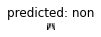

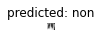

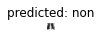

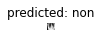

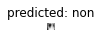

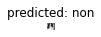

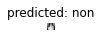

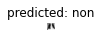

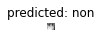

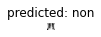

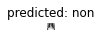

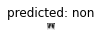

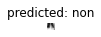

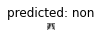

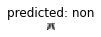

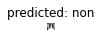

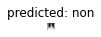

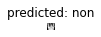

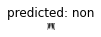

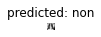

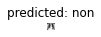

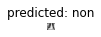

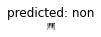

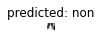

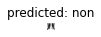

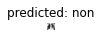

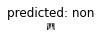

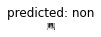

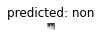

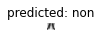

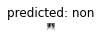

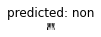

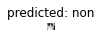

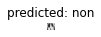

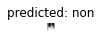

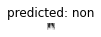

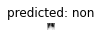

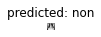

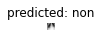

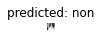

In [24]:
visualize_model(model_conv,num_images= 200)

In [25]:
# load second model Resnet 50

In [26]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False ## All new operations in the torch.set_grad_enabled(False) block won’t require gradients. 
    ## However, the model parameters will still require gradients.
    
    # Parameters of newly constructed modules have requires_grad=True by default   

num_ftrs = model_conv.fc.in_features        
model_conv.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr= 0.0001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

C:\Users\Homa\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Homa/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, 10, 3)
    model_conv.eval()
    torch.save(model_conv, './covid_resnet50_epoch%d.pt' %100)
  

Epoch 1/3
----------
0 batch inputs shape: torch.Size([20, 3, 224, 224])
0 batch label shape: torch.Size([20])

preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
label: tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
1-th epoch, 1-th batch (size=20), train acc= 1.900 

1 batch inputs shape: torch.Size([20, 3, 224, 224])
1 batch label shape: torch.Size([20])

preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
1-th epoch, 2-th batch (size=20), train acc= 2.000 

2 batch inputs shape: torch.Size([20, 3, 224, 224])
2 batch label shape: torch.Size([20])

preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])
1-th epoch, 3-th batch (size=20), train acc= 1.900 

3 batch inputs shape: torch.Size([20, 3, 224, 224])
3 batch label shape: torch.Size([20])

